# Regression Experiments 2

My previous notebook was getting a little bit messy, so I decided to make this to make the code a little more structured. This notebook includes some convenience functions, which should make the experiments a little more readable.

# Setup:

---

In [59]:
# Required imports
import pandas as pd
import json

rounded_train = pd.read_csv('../data/train_with_rounded_score.csv')
rounded_test = pd.read_csv('../data/test_with_rounded_score.csv')
raw_train = pd.read_csv('../data/train_with_raw_score.csv')
raw_test = pd.read_csv('../data/test_with_raw_score.csv')
fips_map = open('../data/fips_map.json')
fips_map = json.load(fips_map)

In [60]:
# Convenience function to get coordinates from fips code
from functools import lru_cache
@lru_cache(maxsize=10000)
def fips_to_coordinate(fips_code):
    fips_code = str(fips_code)
    if fips_code in fips_map:
        return [fips_map[fips_code]['lat'], fips_map[fips_code]['long']]
    else:
        return [None, None]


In [61]:
#add a lat and long column without dropping the fips column
def interpret_fips(df):
    '''Turn the fips column into a latitude/longitude pair'''
    coords = pd.DataFrame(df['fips'].apply(fips_to_coordinate).tolist(), columns=['lat', 'long'])
    df = pd.concat([df, coords], axis=1)
    return df

In [62]:
def add_lag_features(groupbykey:str,shiftcol:str,shiftnum:int,basenum:int,df:pd.DataFrame):
    '''
    This convenience function lags the shiftcol by num_weeks after grouping by groupby.
    The basenum is the number of weeks to ignore before adding lag. For example, 
    If you want to lag the most recent week, you would have a base of 0, and a num_weeks of 1.
    If you want to lag only the week before the most recent week, you would have a base of 1, and a num_weeks of 1. 
    The shiftcol is the metric you want to add lag features for.
    '''
    for i in range(basenum+1,shiftnum+1):
        df[f'{shiftcol}_lag_{i}'] = df.groupby([groupbykey])[shiftcol].shift(i)
    return df

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def regression_metric(y_true,y_pred,title:str):
    '''Generates a standard regression metric set, as well as a scatter plot to visualize'''
    plt.figure(figsize=(20,10))
    plt.scatter(y_true, y_pred)
    plt.scatter(y_true, y_true)
    plt.title(title+" Predictions vs Actuals")
    plt.legend(['Model','Truth'])
    plt.xlabel('Real Score')
    plt.ylabel('Predicted Score')
    plt.show()

    # Error metrics
    print("Mean Squared Error: ", mean_squared_error(y_true, y_pred))
    print("Mean Absolute Error: ", mean_absolute_error(y_true, y_pred))
    print("R2 Score: ", r2_score(y_true, y_pred))


In [64]:
def shift_target(df:pd.DataFrame, num_weeks:int, target_col:str, groupy:str)->pd.DataFrame:
    '''Shifts the target column by num_weeks after grouping by groupy.'''
    '''The target_col should be the name of the column you are trying to predict.'''
    '''The groupy should be the column you are grouping by. (Most often for us, this will be 'fips')'''
    '''The num_weeks should be the number of weeks you want to shift the target column by.(How far out you want to predict)'''
    '''The df should be the dataframe you are working with.'''

    df[target_col] = df.groupby([groupy])[target_col].shift(-num_weeks)
    return df

# Experiments:

---

### Basic Catboost Regressor with default parameters, score lag of 4 weeks.

---

In [65]:
train2 = raw_train.copy()  #REQUIRED STEP
test2 = raw_test.copy() #REQUIRED STEP

In [66]:
train2 = interpret_fips(train2) #REQUIRED STEP
test2 = interpret_fips(test2) #REQUIRED STEP
train2.set_index('date',inplace=True) #REQUIRED STEP
test2.set_index('date',inplace=True) #REQUIRED STEP
train2 = add_lag_features('fips','score',4,0,train2) #can play around with these
test2 = add_lag_features('fips','score',4,0,test2)

In [67]:
NUM_WEEKS_TO_FORECAST = 1

In [68]:
train2 = shift_target(train2, NUM_WEEKS_TO_FORECAST, 'score', 'fips') #REQUIRED STEP, but you can change the number of weeks to forecast
test2 = shift_target(test2, NUM_WEEKS_TO_FORECAST, 'score', 'fips')

In [69]:
train2.drop(['fips'],axis=1,inplace=True) #REQUIRED STEP
test2.drop(['fips'],axis=1,inplace=True) #REQUIRED STEP
train2.dropna(inplace=True) #REQUIRED STEP
test2.dropna(inplace=True)  #REQUIRED STEP

In [70]:
from catboost import CatBoostRegressor

model2 = CatBoostRegressor()

model2.fit(train2.drop(['score'],axis=1),train2['score'], verbose=False)

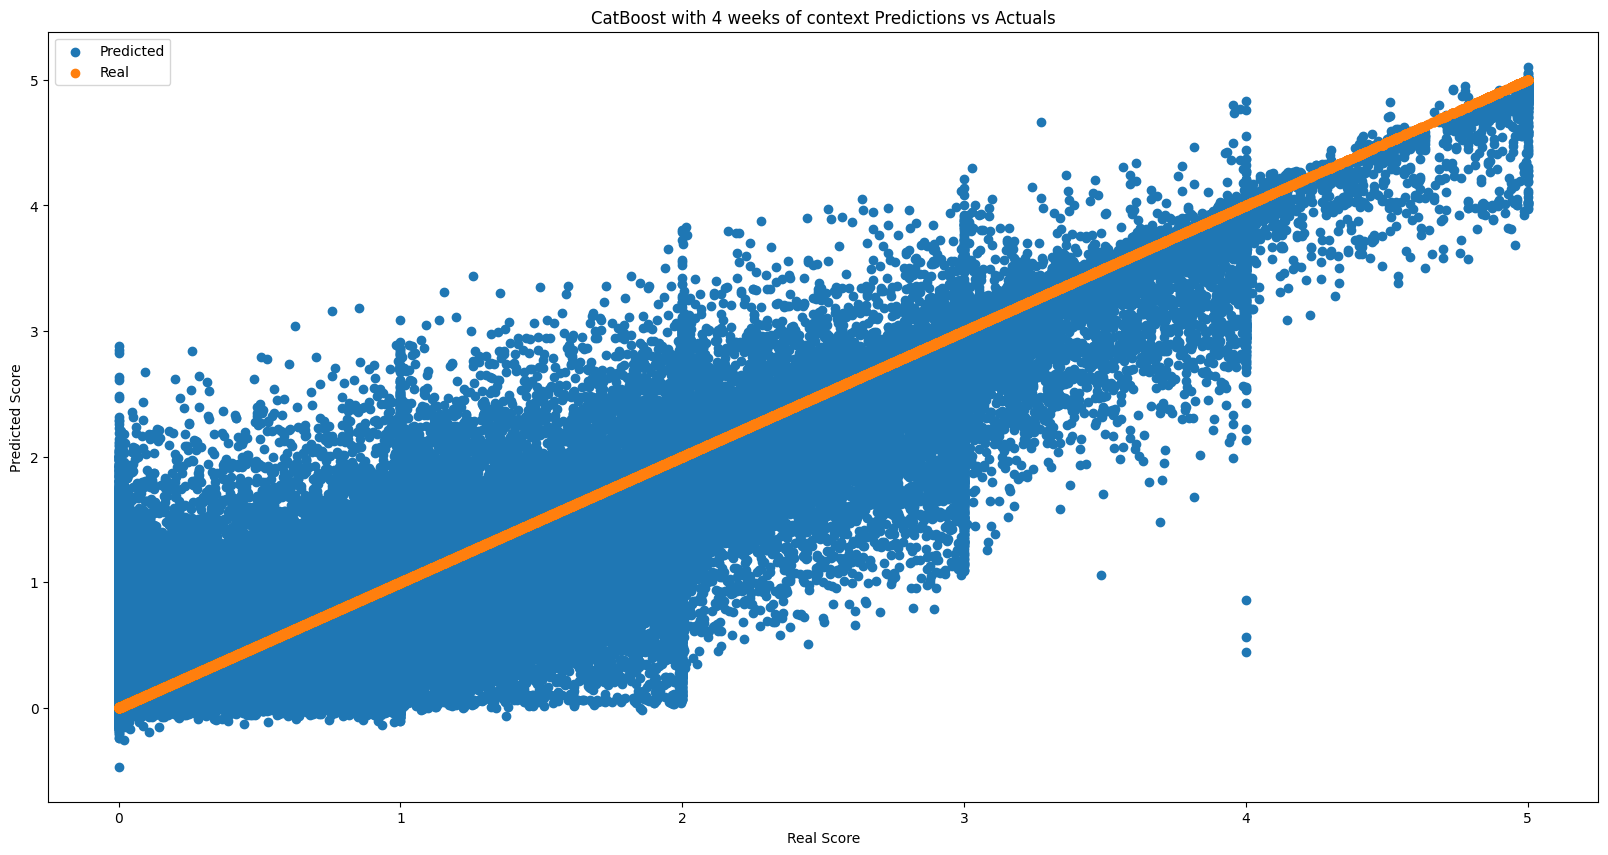

Mean Squared Error:  0.10298512832055014
Mean Absolute Error:  0.17302552702864524
Mean Absolute Percentage Error:  246714846078534.28
R2 Score:  0.8554472329258824


In [71]:
model2_preds = model2.predict(test2.drop(['score'],axis=1))

regression_metric(test2['score'], model2_preds, 'CatBoost with 4 weeks of context')

In [75]:
from catboost import CatBoostRegressor
def cbm_model(num_weeks_to_forecast):
    '''wraps all of the logic above into a single function'''
    _train = raw_train.copy()
    _test = raw_test.copy()
    _train = interpret_fips(_train)
    _test = interpret_fips(_test)
    _train.set_index('date',inplace=True)
    _test.set_index('date',inplace=True)
    _train = add_lag_features('fips','score',4,0,_train)
    _test = add_lag_features('fips','score',4,0,_test)
    _train = shift_target(_train, num_weeks_to_forecast, 'score', 'fips')
    _test = shift_target(_test, num_weeks_to_forecast, 'score', 'fips')
    _train.drop(['fips'],axis=1,inplace=True)
    _test.drop(['fips'],axis=1,inplace=True)
    _train.dropna(inplace=True)
    _test.dropna(inplace=True)
    _model = CatBoostRegressor()
    _model.fit(_train.drop(['score'],axis=1),_train['score'], verbose=False)
    _model_preds = _model.predict(_test.drop(['score'],axis=1))
    regression_metric(_test['score'], _model_preds, f'CatBoost with 4 weeks of context, forecasting {num_weeks_to_forecast} weeks ahead')
    return _model   

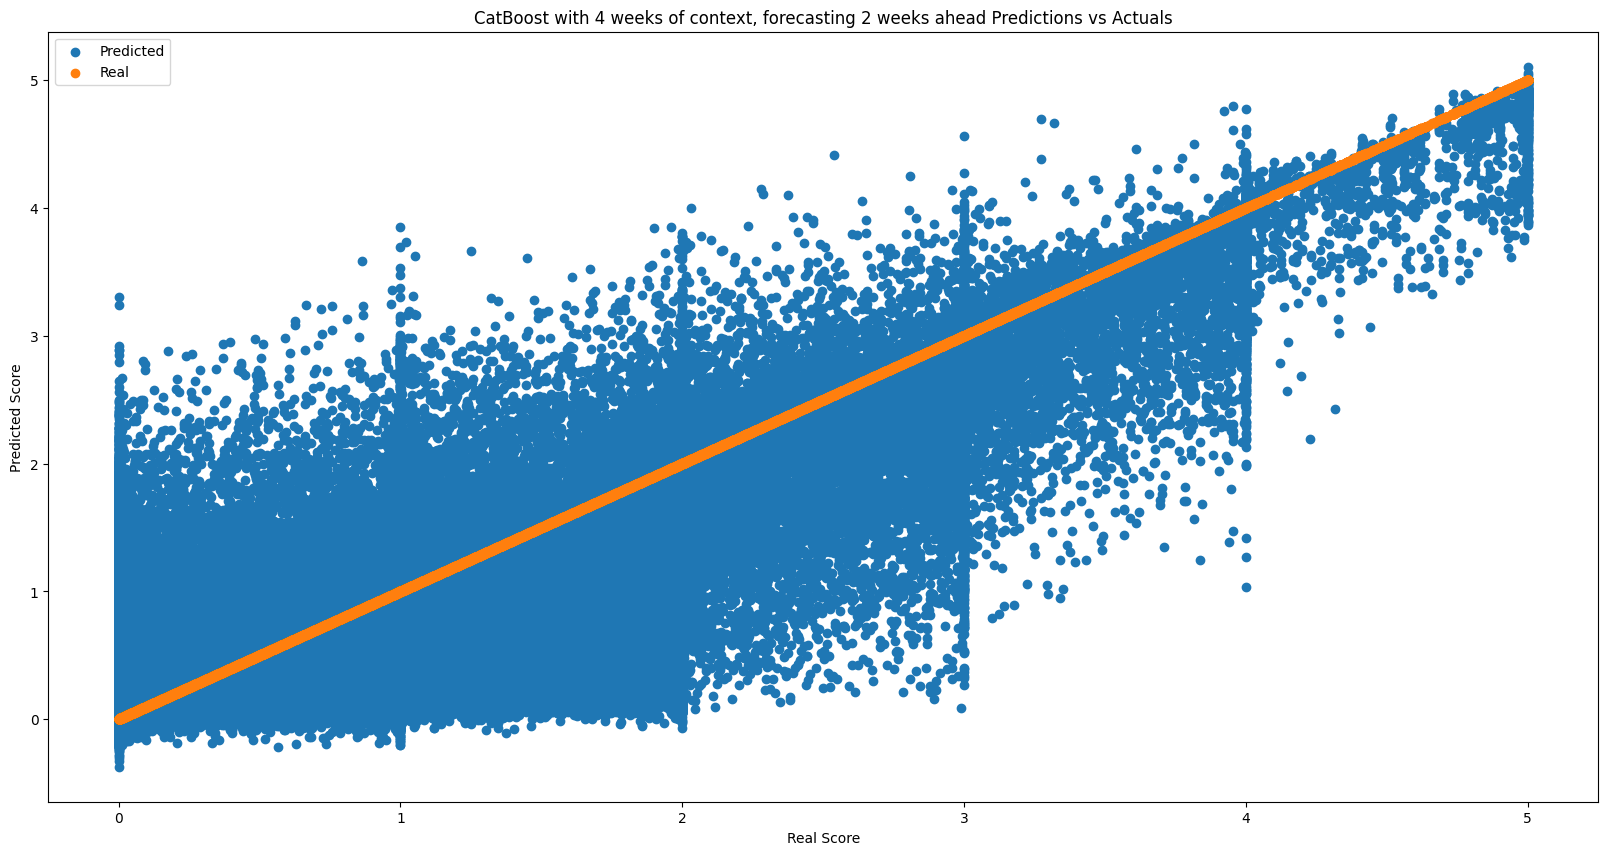

Mean Squared Error:  0.15905894535038387
Mean Absolute Error:  0.23070245007359735
Mean Absolute Percentage Error:  361979271442672.1
R2 Score:  0.7776244687679325


In [76]:
cbm_model(2)

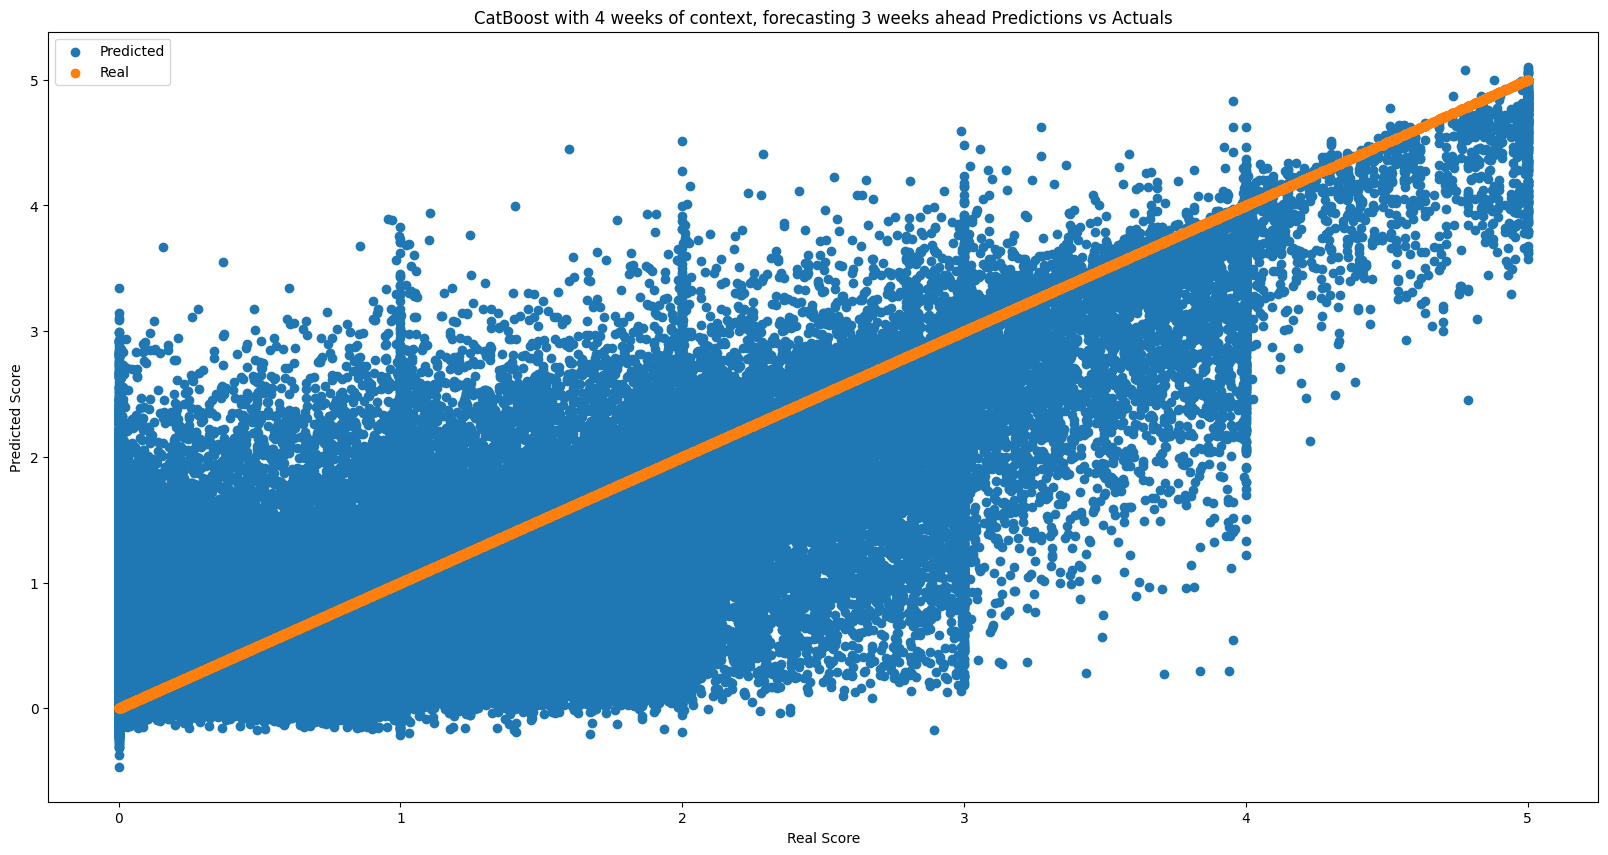

Mean Squared Error:  0.21647235239802437
Mean Absolute Error:  0.2813972707527741
Mean Absolute Percentage Error:  471434156743641.0
R2 Score:  0.6986475132662542


In [77]:
cbm_model(3)

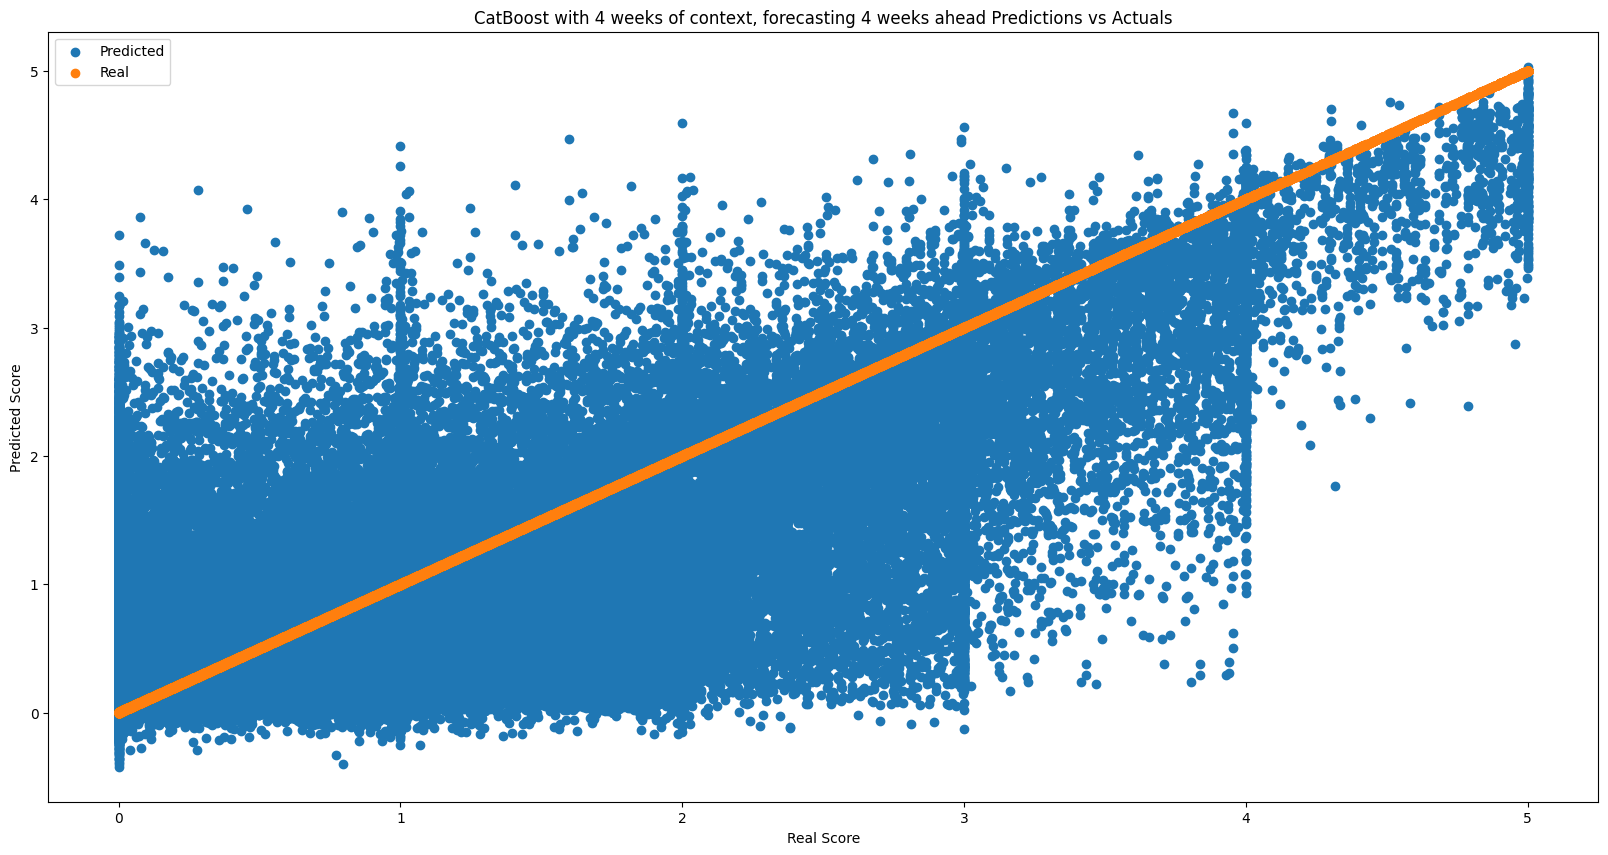

Mean Squared Error:  0.2736729260587206
Mean Absolute Error:  0.32626078414695003
Mean Absolute Percentage Error:  574751068893957.1
R2 Score:  0.6208037087985516


In [78]:
cbm_model(4)